In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Exercise 1: 

## Question 2:

In [43]:
def F(x, X, p):
    """ Cumulative Distribution Function F
    Parameters:
        X (list): list
        x (float): value
        p (list): probas
    Returns:
        k (int): as defined in the algorithm
    """
    n = len(X)
    proba = 0.0
    for k in range(n):
        if X[k] <= x:
            proba += p[k]
        else:
            break
    return proba


def algorithm1(X, p, cdf, n_sample):
    """ Algorithm 1 
    Parameters:
        X (list): list 
        p (list): probas
        n_sample (int): number of samples
    Returns:
        k (list): as defned in the algorithm
    """
    U = np.random.uniform(0, 1, n_sample)
    list_k = []
    for u in U:
        cumulative_sum = 0
        for idx, prob in enumerate(p):
            cumulative_sum += prob
            if cumulative_sum >= u:
                list_k.append(X[idx])
                break
    return list_k

n = 10 ** 4    # Dimension of the space
prob_vector = np.random.rand(n) / n
X = np.random.randint(0, 10 ** 5,
                      size = n)
X = np.sort(X)
X_simul = algorithm1(X, prob_vector, F, 100)
print("Random simulations from X:", np.random.choice(X_simul, 10, replace=False))

Random simulations from X: [76731 82141 51897 76699 68945  3693 91699 38617 46775 95848]


## Question 3:

We test our implementation on $(X_i)_{i \in \left[ 1,n \right]}$ from a $\mathcal{G} (p) $ distribution. 

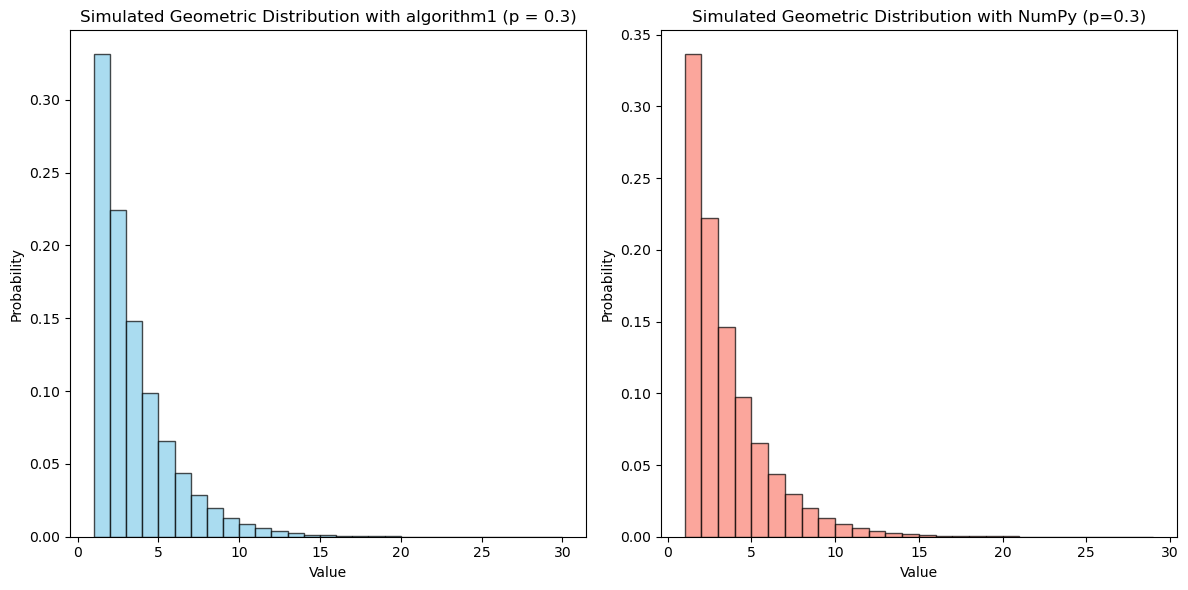

In [44]:
import scipy.stats as stats

p = 1 / 3
X = np.arange(1, 1000)
n_samples = 500_000
prob_vector = (1 - p) ** (X - 1) * p
prob_vector /= prob_vector.sum()

n_samples = 10 ** 5
samples_custom = algorithm1(X, prob_vector, F, n_samples)
samples_numpy = np.random.geometric(p, n_samples)

# Plot the histogram of both samples for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(samples_custom, bins = range(1, max(samples_custom) + 1), density = True, alpha=0.7, color = 'skyblue', edgecolor = 'black')
plt.title("Simulated Geometric Distribution with algorithm1 (p = 0.3)")
plt.xlabel("Value")
plt.ylabel("Probability")

plt.subplot(1, 2, 2)
plt.hist(samples_numpy, bins = range(1, max(samples_numpy) + 1), density = True, alpha = 0.7, color='salmon', edgecolor = 'black')
plt.title("Simulated Geometric Distribution with NumPy (p=0.3)")
plt.xlabel("Value")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# Exercise 2:

## Question 2:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


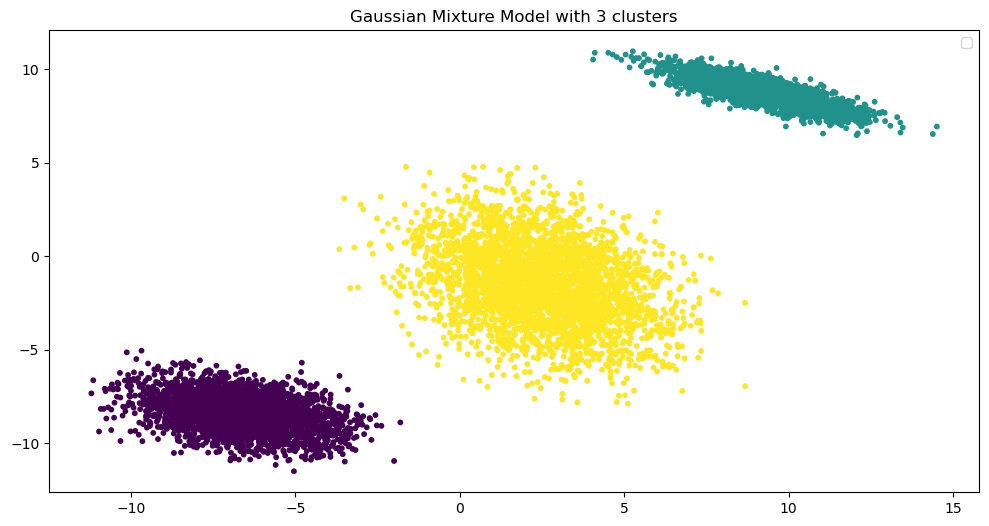

In [84]:
np.random.seed(2001)
def sample_gaussian_mixture(alpha, mu, sigma, n_samples):
    """ Sample from a Gaussian mixture distribution
    Parameters:
    ----------
    alpha (list): list of weights of the Gaussian components
    mu (list): list of means of the Gaussian components
    sigma (list): list of standard deviations of the Gaussian components
    n_samples (int): number of samples to draw
    
    Returns:
    --------
    X (list): sample from the Gaussian mixture distribution
    z (list): class of each sample
    """
    z = algorithm1(np.arange(len(alpha)), alpha, F, n_samples)
    means = mu[z]
    covs = sigma[z]
    sample_gaussian_mixture = np.array([np.random.multivariate_normal(mean, cov, 1) for mean, cov in zip(means, covs)]).reshape(n_samples, -1)
    return sample_gaussian_mixture, z

def generate_invertible_matrices(n_clusters, d):
    """ Generate n_clusters invertible matrices of size (n_dim, n_dim) """
    matrix = []
    while len(matrix) < n_clusters:
        A = np.random.randn(d, d)  # Matrice aléatoire
        sdp_matrix = np.dot(A.T, A) + np.eye(d) * 1e-1  
        matrix.append(sdp_matrix)
    return np.array(matrix)

n_samples = 10 ** 4
n_clusters = 3
n_dim = 2
# Initialize the parameters of the Gaussian mixture (alpha (uniform distribution), mu, sigma)
alpha, mu, sigma = np.array(n_clusters * [1 / n_clusters]), np.random.uniform(-10, 10, size = (n_clusters, n_dim)), generate_invertible_matrices(n_clusters, n_dim)
X, z = sample_gaussian_mixture(alpha, mu, sigma, n_samples)

plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c = z, cmap = 'viridis', s = 10)
plt.title("Gaussian Mixture Model with 3 clusters")
plt.legend()
plt.show()

## Question 3: 

The Expectation-Maximization (EM) algorithm is an iterative method for finding a local maximum of the likelihood. This technique applies to any mixture model (in fact, any model with latent variables).

Given the latent variables, the log-likelihood becomes (we keep the notations of the exercise):

$ l(\theta ; z) = \log p_{\theta} (x, z) =  \displaystyle \sum _{i=1} ^m \alpha _i + \displaystyle \sum _{i=1} ^m \frac{d \mathbb{P} _{X | \theta, Z = i}}{d \lambda} (x)$ 

so that each set of parameters $(\mu _1, \sigma _1),...,( \mu _m, \sigma _m)$ can be estimated separately using the corresponding samples.

In [96]:
def algorithme_EM(X, n_clusters, n_iter):
    """ EM algorithm for Gaussian Mixture Models
    Parameters:
    ----------
    X (list): data
    n_clusters (int): number of clusters
    n_iter (int): number of iterations
    
    Returns:
    --------
    alpha (list): weights of the Gaussian components
    mu (list): means of the Gaussian components
    sigma (list): standard deviations of the Gaussian components
    """
    n_samples, n_dims = X.shape
    evolution_log_likelihood = []

    def init_parameters():
        m = X.mean(axis=0) # (n_dims,)
        s2 = ((X-m)**2).mean() # (1,)
        sigma = np.zeros((n_clusters, n_dims, n_dims))
        for i in range(n_clusters):
            sigma[i] = (s2/n_clusters) * np.eye(n_dims)
        alpha = np.ones(n_clusters) / n_clusters
        mu = np.random.randn(n_clusters, X.shape[1])
        return alpha, mu, sigma
    # Initialization of the parameters 
    alpha, mu, sigma = init_parameters()

    def compute_beta(mu_t, sigma_t, alpha_t):
        """ Compute the beta parameters """
        BETA = np.zeros((n_samples, n_clusters))   # Initialize the beta matrix
        # Invert each covariance matrix in sigma_t for use in the Gaussian density calculation
        inv_sigma_t = np.linalg.inv(sigma_t + 1e-6 * np.eye(n_dims))  # Adding a small value to ensure numerical stability

        # Loop over each cluster to compute the responsibility of each sample for this cluster
        for j in range(n_clusters):
            # Calculate the difference between each sample in X and the mean of the cluster j
            diff = X - mu_t[j][None, :]

            # Compute the exponent part of the Gaussian probability density
            # This uses the Mahalanobis distance formula: (X - mu)^T * Sigma^-1 * (X - mu)
            exponent = np.einsum('ij,jk,ik->i', diff, inv_sigma_t[j], diff)

            # Calculate the responsibility (unnormalized) for each sample belonging to cluster j
            # This is done using the Gaussian density formula: alpha / sqrt(det(Sigma)) * exp(-0.5 * exponent)
            BETA[:, j] = (alpha_t[j] / np.sqrt(np.linalg.det(sigma_t[j]))) * np.exp(-0.5 * exponent)

        BETA /= BETA.sum(axis=1, keepdims=True)
        return BETA
    
    def compute_likelihood(mu_t, sigma_t, alpha_t):
        """ Compute the log-likelihood of the model """
        density = np.zeros((n_samples, n_clusters)) # matrix of phi_j(x_i)
        inv_sigma_t = np.linalg.inv(sigma_t + 1e-6 * np.eye(n_dims))
        for j in range(n_clusters):
            diff = X - mu_t[j][None,:]
            exponent = np.einsum('ij,jk,ik->i', diff, inv_sigma_t[j], diff)
            density[:,j] = (alpha_t[j] / np.sqrt(np.linalg.det(sigma_t[j]) * 2 * np.pi**n_dims)) * np.exp(-0.5 * exponent)
        likelihood = np.sum(np.log(density.sum(axis=1)))
        return likelihood
    
    for i in range(n_iter):
        # E-step
        BETA = compute_beta(mu, sigma, alpha)

        # M-step
        sum_beta = BETA.sum(axis = 0)
        alpha = sum_beta / n_samples
        alpha = alpha / np.sum(alpha)
        for j in range(n_clusters):
            for i in range(n):
                mu[j] += BETA[i,j] * X[i] 
            mu[j] = mu[j] / sum_beta[j]
        for j in range(n_clusters):
            for i in range(n):
                sigma[j] += BETA[i,j]* np.outer((X[i] - mu[j]),(X[i] - mu[j])) + np.eye(n_dims) * 0.01 
            sigma[j] = sigma[j]/sum_beta[j]
        evolution_log_likelihood.append(compute_likelihood(mu, sigma, alpha))
    return alpha, mu, sigma, evolution_log_likelihood


Predicted means: [0.3385     0.33790082 0.32359918]
Predicted standard deviations: [[ 9.22915169  8.75423152]
 [ 2.45248207 -1.46542909]
 [-6.66541221 -8.36975545]]


ValueError: x and y must have same first dimension, but have shapes (100,) and (10,)

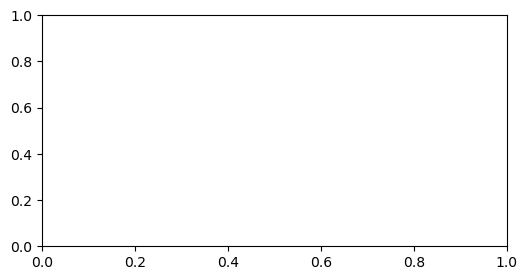

In [98]:
mu_pred, sigma_pred, alpha_pred, likelihoods_pred = algorithme_EM(X, n_clusters, n_iter = 100)
print("Predicted means:", mu_pred)  
print("Predicted standard deviations:", sigma_pred)
plt.figure(figsize=(6,3))
plt.plot(range(0,1000,10), likelihoods_pred[::10])
plt.title('Likelihood over the number of steps')
plt.xlabel('Steps')
plt.ylabel('Likelohood')
plt.xticks(np.arange(0, len(likelihoods_pred), 10))
plt.show()

## Question 4: Are the estimated parameters far from the original ones ?

ValueError: cannot reshape array of size 2 into shape (1,1)

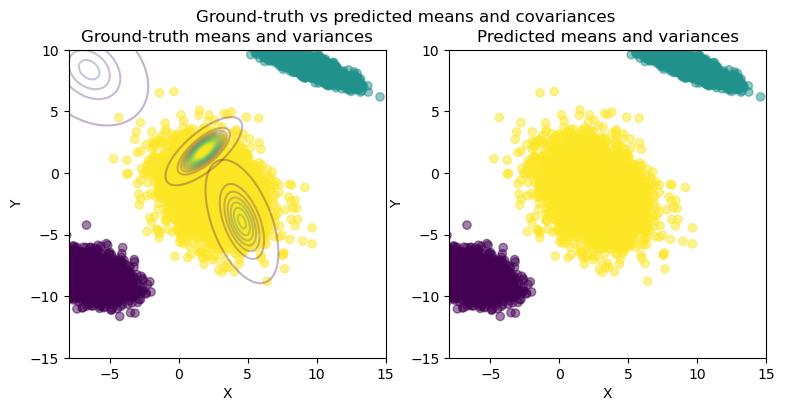

In [85]:
def plot_results(X, z, mu, sigma, ax, title, xlabel='X', ylabel='Y', levels=15, min_level=1e-3, max_level=0.3, alpha_scatter=0.5, alpha_ellipse=0.3, xlim=None, ylim=None):
    x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 1000), 
                   np.linspace(X[:, 1].min(), X[:, 1].max(), 1000))
    pos = np.dstack((x, y))
    levels = np.linspace(min_level, max_level, levels)
    
    ax.set_title(title)
    ax.scatter(X[:,0], X[:,1], c=z, alpha=alpha_scatter)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim is not None:
        ax.set_xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        ax.set_ylim(bottom=ylim[0], top=ylim[1])
    for m, s in zip(mu, sigma):
        rv = stats.multivariate_normal(m, s)
        ax.contour(x, y, rv.pdf(pos), levels=levels, alpha=alpha_ellipse)

n_samples = 10 ** 4
n_clusters = 3
n_dim = 2
# Initialize the parameters of the Gaussian mixture (alpha (uniform distribution), mu, sigma)
true_alpha, true_mu, true_sigma = np.array(n_clusters * [1 / n_clusters]), np.random.uniform(-10, 10, size = (n_clusters, n_dim)), generate_invertible_matrices(n_clusters, n_dim)
X, z = sample_gaussian_mixture(alpha, mu, sigma, n_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
fig.suptitle(f'Ground-truth vs predicted means and covariances')
plot_results(
            X, 
            z, 
            true_mu, 
            true_sigma, 
            ax1, 
            'Ground-truth means and variances',
            xlim=(-8,15),
            ylim=(-15,10)
)

plot_results(
            X, 
            z, 
            mu_pred, 
            sigma_pred, 
            ax2, 
            'Predicted means and variances',
            xlim=(-8,15),
            ylim=(-15,10)
)
plt.tight_layout()
plt.show()

In [80]:
sigma

array([[[-1.07526523,  0.79105663],
        [-0.97193426, -0.36211642]],

       [[-1.17253026,  0.57699961],
        [ 0.5657157 , -0.07937917]],

       [[ 0.2860647 ,  1.8927897 ],
        [-1.80521625,  0.9124228 ]]])